In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import bs4
import codecs
import re
import random
import pickle as pkl
import json
import re

The first step in our cleaning procedure is to find the websites which recepie data is collected from. This helps us create a scraper per website

In [2]:
links = os.listdir('recipePages')

In [ ]:
# NOTE : please don't run just load pickle
website_map = dict({})
i = 0
for link in links:

    f = codecs.open('./recipePages/' + link, 'r', 'utf-8', errors='ignore')
    document = BeautifulSoup(f.read(),'html.parser')
    try:
        a = document.body.find('a')
        website_name = a['href']
        website_url = re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', website_name)
        
        if website_url!=[]:
            website_url = website_url[0]
            if website_url in website_map:
                website_map[website_url].append(link)
            else:
                website_map[website_url] = [link]
        
        if (i%10000 == 0) and (i>0) :
            with open('./pickles/recepie_to_websites' + str(i) + '.pkl', 'wb') as f:
                pkl.dump(website_map, f)
        
        i+=1
        
    except:
           continue

with open('./pickles/recepie_to_websites.pkl', 'wb') as f:
    pkl.dump(website_map, f)

In [3]:
with open('./pickles/recepie_to_websites.pkl', 'rb') as f:
    website_map = pkl.load(f) # a map having for each url a list of all html files belonging to it

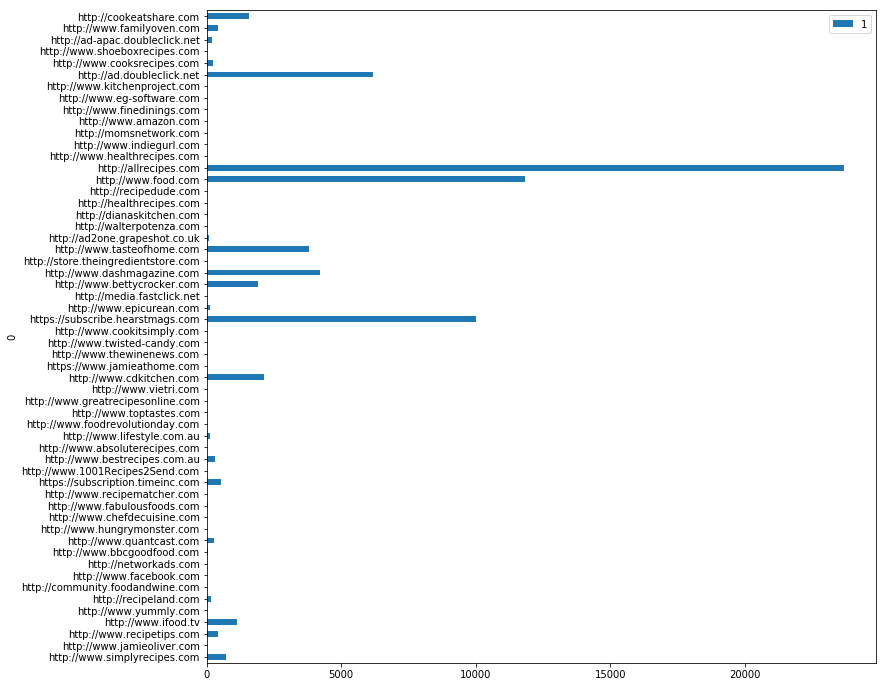

In [4]:
plt.rcParams['figure.figsize'] = [12,12]
website_distribution = dict()
for key in website_map.keys():
    website_distribution[key] = len(website_map[key])
web_dist_df = pd.DataFrame(website_distribution.items())
web_dist_df = web_dist_df.set_index(0)
web_dist_df.plot.barh()

In [4]:
def parse_food_network(links):
    
    final_res = []
    applied = lambda x: x.contents[0] if isinstance(x,bs4.element.Tag) else x
    
    for link in links:
        
        try:
            f = codecs.open('./recipePages/' + link, 'r', 'utf-8', errors='ignore')
            document = BeautifulSoup(f.read(),'html.parser')

            recepie_name = document.find('h1',{'class':'fn'}).contents[0]

            category = map(lambda x : x.contents [0] ,document.find("div", {"class": "more"}).find('ul').findAll('a'))

            rating_info = int(document.find("div",{"class":"rm-block lead hreview-aggregate review"}).find('div')['title'])

            preparation_time = document.find("div",{"class":"rm-block-wrap"})
            prep_time = re.findall('\d+',preparation_time.find('dd',{'class':'prepTime clrfix'}).find('span').contents[0])[0]
            cook_time = re.findall('\d+',preparation_time.find('dd',{'class':'cookTime clrfix'}).find('span').contents[0])[0]
            diff_level = document.findAll('dd',{'class':'clrfix'})[-1:][0].contents[0]

            reviews = map(lambda x : x.contents[0].strip(),document.findAll('p',{'class':'quote'}))
            review_dates = document.findAll('div',{'class':'about-recipe-info'})
            review_dates = map(lambda x : x.findAll('p')[-1].contents[0][2:],review_dates)
            
            review_info = list(zip(reviews,review_dates))
            
            for review in review_info:

                data = {
                    'name':recepie_name,
                    'category':category,
                    'review':review[0],
                    'review_date':review[1],
                    'rating':rating_info,
                    'prep_time':prep_time,
                    'cook_time':cook_time,
                    'difficulty':diff_level
                }
                final_res.append(data)
        
        except: 
            continue
    
    return final_res

In [ ]:
food_net_result = parse_food_network(website_map['https://subscribe.hearstmags.com'])
with open('./pickles/food_net.json', 'w') as fout:
    json.dump(food_net_result, fout)

In [ ]:

#NOTE : you can use this code to open files of the dataset in the browser
'''
import webbrowser
new=2
urls = [website_map['https://subscribe.hearstmags.com'][0]]
for link in urls:
    webbrowser.open('recipePages/'+ link,new=new)
'''

In [8]:
def parse_allrecepies(links):
    
    final_res = []
    
    for link in links:
        
        try:
            f = codecs.open('./recipePages/' + link, 'r', 'utf-8', errors='ignore')
            document = BeautifulSoup(f.read(),'html.parser')

            recepie_name    = document.find('span',{'class','itemreviewed'}).contents[0]
            rating          = int(re.findall('\d',document.find('p',{'class':'reviewP'}).find('img')['title'])[0])

            serving_info    = document.find('div',{'class':'servings-form'}).find('input')['value']
            
            timing_data     = document.find('div',{'class':'times'})
            if timing_data is not None:
                prep_time  = timing_data.find('span',{'class':'prepTime'}).find('span')['title'][2:]
                cook_time  = timing_data.find('span',{'class':'cookTime'}).find('span')['title'][2:]
                total_time = timing_data.find('span',{'class':'totalTime'}).find('span')['title'][2:]
            else:
                prep_time  = -1
                cook_time  = -1
                total_time = -1
                
            

            nutrition_facts  = document.find('div',{'id':'nutri-info'}).findAll('span')
            nutrition_facts  = map(lambda x : {x['class'][0] : x.contents[0]} ,nutrition_facts)
            nutrition_info   = dict()
            for subDict in nutrition_facts:
                key = subDict.keys()[0]
                nutrition_info[key] = subDict[key]

            reviews          = document.findAll('div',{'class':'listItemReviewMini'})
            reviews          = map(lambda x : x.contents[0].strip(),reviews)
            
            review_date      = document.findAll('div',{'class','recreview'})
            review_date      = map(lambda x : x.find('div',{'class','review'}).contents[0].split('\n')[2].strip(),review_date) 
                                       

            review_info = list(zip(reviews,review_date))
                
                
            for review in review_info:
                data = {
                    'name': recepie_name,
                    'rating': rating,
                    'servings':serving_info,
                    'review' : review[0],
                    'prep_time':prep_time,
                    'cook_time':cook_time,
                    'total_time':total_time,
                    'review_date':review[1]
                }
                data.update(nutrition_info)
                final_res.append(data)
        
        except:
            continue
    
    return final_res

In [ ]:
all_recpie_result = parse_allrecepies(website_map['http://allrecipes.com'][0:10000])
with open('./pickles/all_recpie.json', 'w') as fout:
      json.dump(all_recpie_result, fout)

In [6]:
def parse_food_com(links):
    
    final_res = []
    
    for link in links:

        try:
            f = codecs.open('./recipePages/' + link, 'r', 'utf-8', errors='ignore')
            document = BeautifulSoup(f.read(),'html.parser')

            recepie_name     = document.find('h1',{'itemprop':'name'}).contents[0]

            document_posted  = document.find('div',{'class':'addedwhen clrfix'}).find('meta')['content']

            categories       = document.find('p',{"class","recipe-cats"}).findAll('span',{'itemprop':'recipeCategory'})
            categories       = map(lambda x: x.contents[0],categories)

            preparation_time = document.find('div',{'class':'ckTime clrfix'}).find('div',{'class':"ct-e"}).findAll('p')
            preparation_time = map(lambda x : x.contents,preparation_time)
            preparation_time = map(lambda x: {x[0]['itemprop'] : x[1]},preparation_time)

            num_servings     = document.find('select').find('option',{'class':"select-title"}).contents[0]

            nutrition_facts  = document.find('div',{'itemprop':'nutrition'}).findAll('span')
            nutrition_facts  = filter(lambda x : x.has_attr('itemprop'),nutrition_facts)
            nutrition_facts  = map(lambda x : {x['itemprop']:x.contents[0]},nutrition_facts)
            resulting_facts  = dict()
            for subdict in nutrition_facts:
                key = subdict.keys()[0]
                resulting_facts[key] = subdict[key]

            
            user_reviews     = document.findAll('span',{'itemprop':'description'})
            user_reviews     = map(lambda x : x.contents[0],user_reviews)
            
            review_dates     = document.findAll('li',{'itemprop':'reviews'})
            review_dates     = map(lambda x: x.find('meta')['content'],review_dates)

            review_info      = list(zip(user_reviews,review_dates))
            
            
            for review in review_info:

                data = {
                    'name'    : recepie_name,
                    'date'    : document_posted,
                    'category': categories,
                    'review'  : review[0],
                    'review_date': review[1],
                    'servings': num_servings
                }
                data.update(preparation_time[0])
                data.update(preparation_time[1])
                data.update(resulting_facts)
                final_res.append(data)
        except:
            continue
            
        
    return final_res

In [ ]:
food_com_result = parse_food_com(website_map['http://www.food.com'])
with open('./pickles/food_com.json', 'w') as fout:
    json.dump(all_recpie_result, fout)

In [5]:
len(website_map['https://subscribe.hearstmags.com'])

9998

In [6]:
len(website_map['http://www.food.com'])

11842

In [7]:
len(website_map['http://allrecipes.com'])

23697